# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

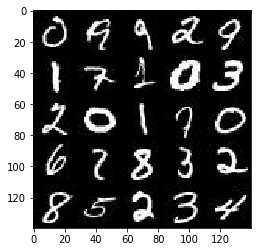

In [2]:
show_n_images = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

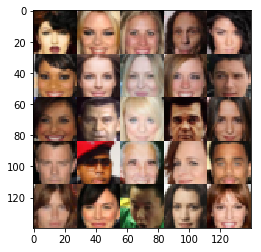

In [3]:
show_n_images = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        #28*28*3
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        
        #14*14*64
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        #7*7*128
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        #4*4*256
        flat = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        alpha = 0.01
        
        x = tf.layers.dense(z, 7*7*128)
        x = tf.reshape(x, (-1, 7, 7, 128))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        # 7*7*128
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        # 7*7*64
        x = tf.layers.conv2d_transpose(x, 32, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)

        #14*14*32
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        
        # 28*28*out_dim
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real =  tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 1 ))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    output_dim = data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, output_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, output_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
     
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} Batch {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, output_dim, data_image_mode)
                    
            show_generator_output(sess, 25, input_z, output_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Batch 100... Discriminator Loss: 0.5947... Generator Loss: 1.9953
Epoch 1/2 Batch 200... Discriminator Loss: 1.1914... Generator Loss: 0.7866
Epoch 1/2 Batch 300... Discriminator Loss: 0.9679... Generator Loss: 1.0722
Epoch 1/2 Batch 400... Discriminator Loss: 1.2551... Generator Loss: 0.6332
Epoch 1/2 Batch 500... Discriminator Loss: 1.2649... Generator Loss: 0.5285


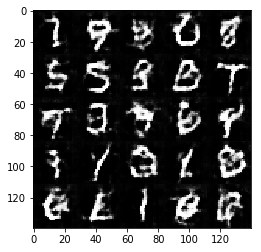

Epoch 1/2 Batch 600... Discriminator Loss: 1.1615... Generator Loss: 1.0214
Epoch 1/2 Batch 700... Discriminator Loss: 1.7726... Generator Loss: 1.2666
Epoch 1/2 Batch 800... Discriminator Loss: 0.9671... Generator Loss: 0.7005
Epoch 1/2 Batch 900... Discriminator Loss: 0.8979... Generator Loss: 1.0489
Epoch 1/2 Batch 1000... Discriminator Loss: 1.4299... Generator Loss: 0.3769


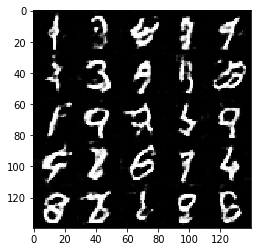

Epoch 1/2 Batch 1100... Discriminator Loss: 1.4002... Generator Loss: 0.4312
Epoch 1/2 Batch 1200... Discriminator Loss: 0.9256... Generator Loss: 1.4364
Epoch 1/2 Batch 1300... Discriminator Loss: 1.2609... Generator Loss: 0.7294
Epoch 1/2 Batch 1400... Discriminator Loss: 1.9116... Generator Loss: 0.2257
Epoch 1/2 Batch 1500... Discriminator Loss: 1.8183... Generator Loss: 0.2366


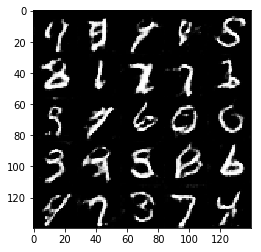

Epoch 1/2 Batch 1600... Discriminator Loss: 0.8281... Generator Loss: 0.9788
Epoch 1/2 Batch 1700... Discriminator Loss: 1.4054... Generator Loss: 0.4563
Epoch 1/2 Batch 1800... Discriminator Loss: 1.7558... Generator Loss: 0.2964
Epoch 1/2 Batch 1900... Discriminator Loss: 1.6421... Generator Loss: 0.3626
Epoch 1/2 Batch 2000... Discriminator Loss: 1.6418... Generator Loss: 2.3706


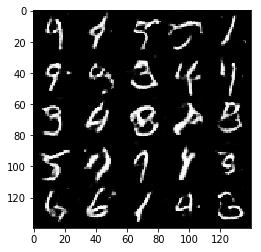

Epoch 1/2 Batch 2100... Discriminator Loss: 0.5107... Generator Loss: 1.5892


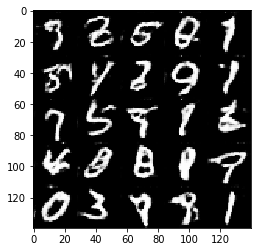

Epoch 2/2 Batch 100... Discriminator Loss: 1.0325... Generator Loss: 0.7291
Epoch 2/2 Batch 200... Discriminator Loss: 0.8834... Generator Loss: 1.2452
Epoch 2/2 Batch 300... Discriminator Loss: 1.0761... Generator Loss: 0.5835
Epoch 2/2 Batch 400... Discriminator Loss: 0.6224... Generator Loss: 1.8870
Epoch 2/2 Batch 500... Discriminator Loss: 0.7212... Generator Loss: 1.2733


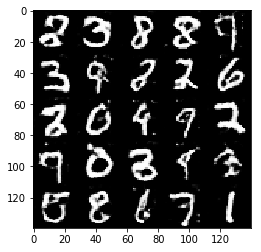

Epoch 2/2 Batch 600... Discriminator Loss: 0.9454... Generator Loss: 2.5942
Epoch 2/2 Batch 700... Discriminator Loss: 1.1071... Generator Loss: 0.5634
Epoch 2/2 Batch 800... Discriminator Loss: 0.6610... Generator Loss: 1.0551
Epoch 2/2 Batch 900... Discriminator Loss: 1.2957... Generator Loss: 4.4225
Epoch 2/2 Batch 1000... Discriminator Loss: 0.6296... Generator Loss: 1.4714


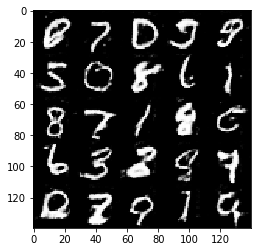

Epoch 2/2 Batch 1100... Discriminator Loss: 0.6744... Generator Loss: 0.9673
Epoch 2/2 Batch 1200... Discriminator Loss: 0.4887... Generator Loss: 1.4397
Epoch 2/2 Batch 1300... Discriminator Loss: 2.9948... Generator Loss: 0.1214
Epoch 2/2 Batch 1400... Discriminator Loss: 1.3569... Generator Loss: 0.4211
Epoch 2/2 Batch 1500... Discriminator Loss: 2.6002... Generator Loss: 0.1341


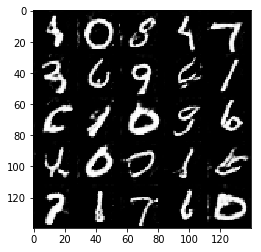

Epoch 2/2 Batch 1600... Discriminator Loss: 1.4826... Generator Loss: 0.4322
Epoch 2/2 Batch 1700... Discriminator Loss: 0.6186... Generator Loss: 1.1919
Epoch 2/2 Batch 1800... Discriminator Loss: 0.6356... Generator Loss: 1.1402
Epoch 2/2 Batch 1900... Discriminator Loss: 1.8931... Generator Loss: 0.2582
Epoch 2/2 Batch 2000... Discriminator Loss: 1.0795... Generator Loss: 0.8515


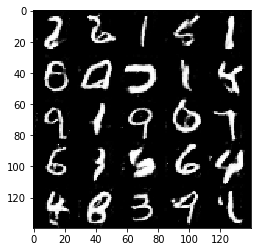

Epoch 2/2 Batch 2100... Discriminator Loss: 1.0827... Generator Loss: 0.5947


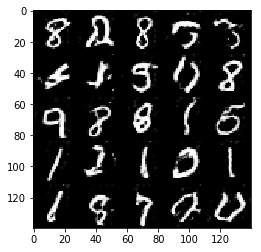

In [12]:
batch_size = 28
z_dim = 128
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch 100... Discriminator Loss: 1.3206... Generator Loss: 0.5243
Epoch 1/1 Batch 200... Discriminator Loss: 0.9423... Generator Loss: 0.7956
Epoch 1/1 Batch 300... Discriminator Loss: 2.4553... Generator Loss: 0.1530
Epoch 1/1 Batch 400... Discriminator Loss: 1.8976... Generator Loss: 0.2549
Epoch 1/1 Batch 500... Discriminator Loss: 0.9300... Generator Loss: 1.0637


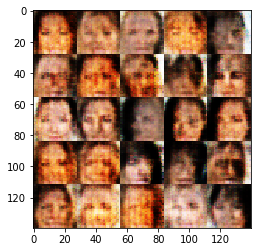

Epoch 1/1 Batch 600... Discriminator Loss: 1.2406... Generator Loss: 1.5738
Epoch 1/1 Batch 700... Discriminator Loss: 1.6383... Generator Loss: 0.4494
Epoch 1/1 Batch 800... Discriminator Loss: 1.4433... Generator Loss: 0.5423
Epoch 1/1 Batch 900... Discriminator Loss: 1.3639... Generator Loss: 0.8038
Epoch 1/1 Batch 1000... Discriminator Loss: 1.7757... Generator Loss: 0.3679


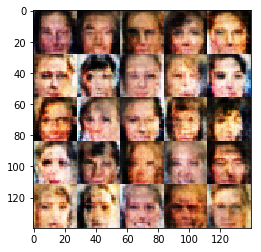

Epoch 1/1 Batch 1100... Discriminator Loss: 1.1262... Generator Loss: 1.0680
Epoch 1/1 Batch 1200... Discriminator Loss: 1.2256... Generator Loss: 0.5982
Epoch 1/1 Batch 1300... Discriminator Loss: 2.1787... Generator Loss: 0.1461
Epoch 1/1 Batch 1400... Discriminator Loss: 1.1152... Generator Loss: 0.8424
Epoch 1/1 Batch 1500... Discriminator Loss: 1.6621... Generator Loss: 0.3058


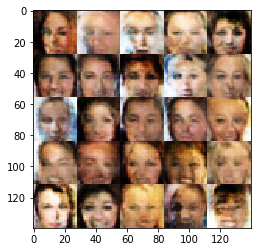

Epoch 1/1 Batch 1600... Discriminator Loss: 1.1218... Generator Loss: 1.0486
Epoch 1/1 Batch 1700... Discriminator Loss: 1.4427... Generator Loss: 0.3902
Epoch 1/1 Batch 1800... Discriminator Loss: 1.2578... Generator Loss: 0.6815
Epoch 1/1 Batch 1900... Discriminator Loss: 1.6352... Generator Loss: 0.3378
Epoch 1/1 Batch 2000... Discriminator Loss: 1.2964... Generator Loss: 0.6454


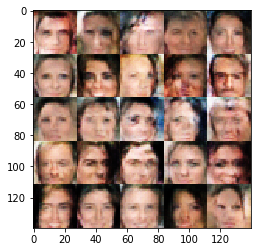

Epoch 1/1 Batch 2100... Discriminator Loss: 1.7036... Generator Loss: 0.2654
Epoch 1/1 Batch 2200... Discriminator Loss: 1.0039... Generator Loss: 0.7374
Epoch 1/1 Batch 2300... Discriminator Loss: 1.2014... Generator Loss: 0.6642
Epoch 1/1 Batch 2400... Discriminator Loss: 1.5312... Generator Loss: 0.3287
Epoch 1/1 Batch 2500... Discriminator Loss: 1.5176... Generator Loss: 0.3498


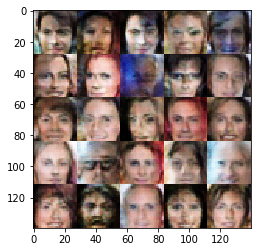

Epoch 1/1 Batch 2600... Discriminator Loss: 1.1897... Generator Loss: 0.5960
Epoch 1/1 Batch 2700... Discriminator Loss: 1.1894... Generator Loss: 0.5916
Epoch 1/1 Batch 2800... Discriminator Loss: 1.3783... Generator Loss: 0.4089
Epoch 1/1 Batch 2900... Discriminator Loss: 1.2327... Generator Loss: 0.6368
Epoch 1/1 Batch 3000... Discriminator Loss: 0.9909... Generator Loss: 1.0116


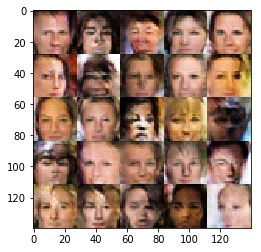

Epoch 1/1 Batch 3100... Discriminator Loss: 1.5001... Generator Loss: 0.3647
Epoch 1/1 Batch 3200... Discriminator Loss: 1.1120... Generator Loss: 0.7183
Epoch 1/1 Batch 3300... Discriminator Loss: 1.1789... Generator Loss: 0.8946
Epoch 1/1 Batch 3400... Discriminator Loss: 1.1898... Generator Loss: 0.6893
Epoch 1/1 Batch 3500... Discriminator Loss: 1.0492... Generator Loss: 0.7876


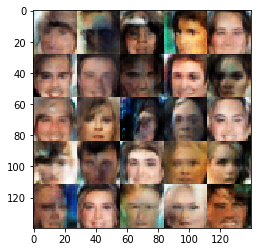

Epoch 1/1 Batch 3600... Discriminator Loss: 1.1759... Generator Loss: 0.6170
Epoch 1/1 Batch 3700... Discriminator Loss: 1.1809... Generator Loss: 0.7705
Epoch 1/1 Batch 3800... Discriminator Loss: 0.9876... Generator Loss: 0.6932
Epoch 1/1 Batch 3900... Discriminator Loss: 1.4699... Generator Loss: 0.3887
Epoch 1/1 Batch 4000... Discriminator Loss: 1.4667... Generator Loss: 0.5472


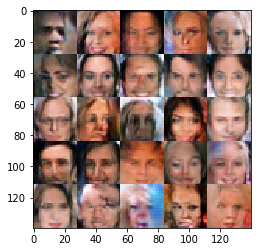

Epoch 1/1 Batch 4100... Discriminator Loss: 1.7069... Generator Loss: 0.3452
Epoch 1/1 Batch 4200... Discriminator Loss: 1.2399... Generator Loss: 0.6349
Epoch 1/1 Batch 4300... Discriminator Loss: 2.0733... Generator Loss: 0.1741
Epoch 1/1 Batch 4400... Discriminator Loss: 1.0428... Generator Loss: 0.7585
Epoch 1/1 Batch 4500... Discriminator Loss: 1.3555... Generator Loss: 0.4796


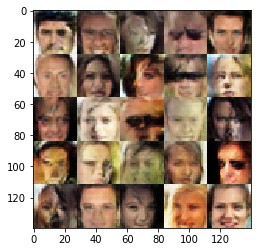

Epoch 1/1 Batch 4600... Discriminator Loss: 1.7884... Generator Loss: 0.2439
Epoch 1/1 Batch 4700... Discriminator Loss: 1.2872... Generator Loss: 0.4761
Epoch 1/1 Batch 4800... Discriminator Loss: 1.3948... Generator Loss: 0.4096
Epoch 1/1 Batch 4900... Discriminator Loss: 1.4799... Generator Loss: 0.3675
Epoch 1/1 Batch 5000... Discriminator Loss: 1.0421... Generator Loss: 1.0280


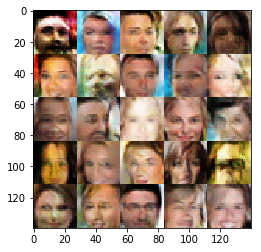

Epoch 1/1 Batch 5100... Discriminator Loss: 1.5881... Generator Loss: 0.9593
Epoch 1/1 Batch 5200... Discriminator Loss: 1.4608... Generator Loss: 0.3896
Epoch 1/1 Batch 5300... Discriminator Loss: 1.5465... Generator Loss: 0.3752
Epoch 1/1 Batch 5400... Discriminator Loss: 1.9795... Generator Loss: 0.1858
Epoch 1/1 Batch 5500... Discriminator Loss: 2.0387... Generator Loss: 0.1903


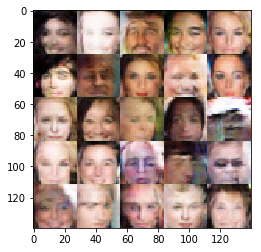

Epoch 1/1 Batch 5600... Discriminator Loss: 1.7383... Generator Loss: 0.2795
Epoch 1/1 Batch 5700... Discriminator Loss: 1.0815... Generator Loss: 1.2861
Epoch 1/1 Batch 5800... Discriminator Loss: 1.2693... Generator Loss: 0.4496
Epoch 1/1 Batch 5900... Discriminator Loss: 1.5932... Generator Loss: 0.4083
Epoch 1/1 Batch 6000... Discriminator Loss: 1.2789... Generator Loss: 0.4606


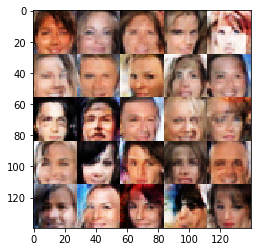

Epoch 1/1 Batch 6100... Discriminator Loss: 1.5443... Generator Loss: 0.3181
Epoch 1/1 Batch 6200... Discriminator Loss: 1.3034... Generator Loss: 0.4712
Epoch 1/1 Batch 6300... Discriminator Loss: 1.0668... Generator Loss: 0.6241
Epoch 1/1 Batch 6400... Discriminator Loss: 1.7069... Generator Loss: 0.2882
Epoch 1/1 Batch 6500... Discriminator Loss: 1.1464... Generator Loss: 0.5951


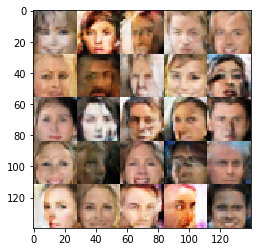

Epoch 1/1 Batch 6600... Discriminator Loss: 1.3802... Generator Loss: 0.3899
Epoch 1/1 Batch 6700... Discriminator Loss: 1.6806... Generator Loss: 0.2956
Epoch 1/1 Batch 6800... Discriminator Loss: 1.4466... Generator Loss: 0.3842
Epoch 1/1 Batch 6900... Discriminator Loss: 1.1225... Generator Loss: 0.5322
Epoch 1/1 Batch 7000... Discriminator Loss: 1.4049... Generator Loss: 0.4092


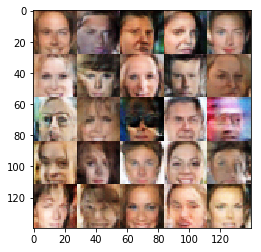

Epoch 1/1 Batch 7100... Discriminator Loss: 1.3093... Generator Loss: 0.4918
Epoch 1/1 Batch 7200... Discriminator Loss: 1.5146... Generator Loss: 0.3917


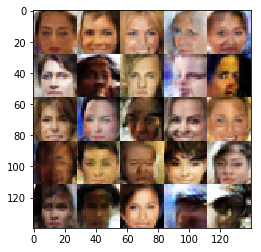

In [13]:
batch_size = 28
z_dim = 128
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.